In [99]:
import math
import random
import re
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import pandas as pd

def doane_formula(data):
    """
    Calculates the optimal number of bins for a histogram using Doane's formula:
    https://en.wikipedia.org/wiki/Histogram#Doane's_formula
    """
    N = len(data)
    skewness = st.skew(data)
    sigma_g1 = math.sqrt((6 * (N - 2)) / ((N + 1) * (N + 3)))
    num_bins = 1 + math.log(N, 2) + math.log(1 + abs(skewness) / sigma_g1, 2)
    return round(num_bins)

def plot_histogram(data, results, n):
    """
    Plots a histogram of the data along with the PDF curves of the top N fitted distributions.
    
    Parameters:
        data : array-like
            Input data to plot
        results : dict
            Fitting results from fit_data()
        n : int
            Number of top distributions to plot
    """
    # Select top N distributions
    N_DISTRIBUTIONS = {k: results[k] for k in list(results)[:n]}

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(data, density=True, ec='white', color=(63/235, 149/235, 170/235))
    plt.title('Histogram')
    plt.xlabel('Values')
    plt.ylabel('Frequencies')

    # Plot fitted distributions
    for distribution, result in N_DISTRIBUTIONS.items():
        sse = result[0]
        arg = result[1]
        loc = result[2]
        scale = result[3]
        x_plot = np.linspace(min(data), max(data), 1000)
        y_plot = distribution.pdf(x_plot, loc=loc, scale=scale, *arg)
        dist_name = re.search(r'_continuous_distns\.(.*?) object', str(distribution)).group(1)
        plt.plot(
            x_plot, y_plot,
            label=f"{dist_name}: {str(sse)[:6]}",
            color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
        )

    plt.legend(title='Distributions', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def fit_data(data):
    """
    Fits selected continuous distributions to the data and calculates the sum of squared errors (SSE).
    
    Returns a dictionary of distributions sorted by SSE.
    """
    # List of all continuous distributions in scipy.stats
    ALL_DISTRIBUTIONS = [d for d in dir(st) if isinstance(getattr(st, d), st.rv_continuous)]

    # Select distributions to fit
    MY_DISTRIBUTIONS = [
        st.beta, st.expon, st.norm,
        st.uniform, st.johnsonsb, st.gennorm,
        st.gausshyper
    ]

    # Calculate optimal number of bins using Doane's formula
    num_bins = doane_formula(data)
    frequencies, bin_edges = np.histogram(data, num_bins, density=True)
    central_values = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]

    results = {}
    for distribution in MY_DISTRIBUTIONS:
        # Fit distribution to data
        params = distribution.fit(data)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Compute fitted PDF values
        pdf_values = [distribution.pdf(c, loc=loc, scale=scale, *arg) for c in central_values]

        # Compute sum of squared errors
        sse = np.sum((frequencies - pdf_values) ** 2)

        # Store results
        results[distribution] = [sse, arg, loc, scale]

    # Sort results by SSE
    results = {k: results[k] for k in sorted(results, key=results.get)}
    return results


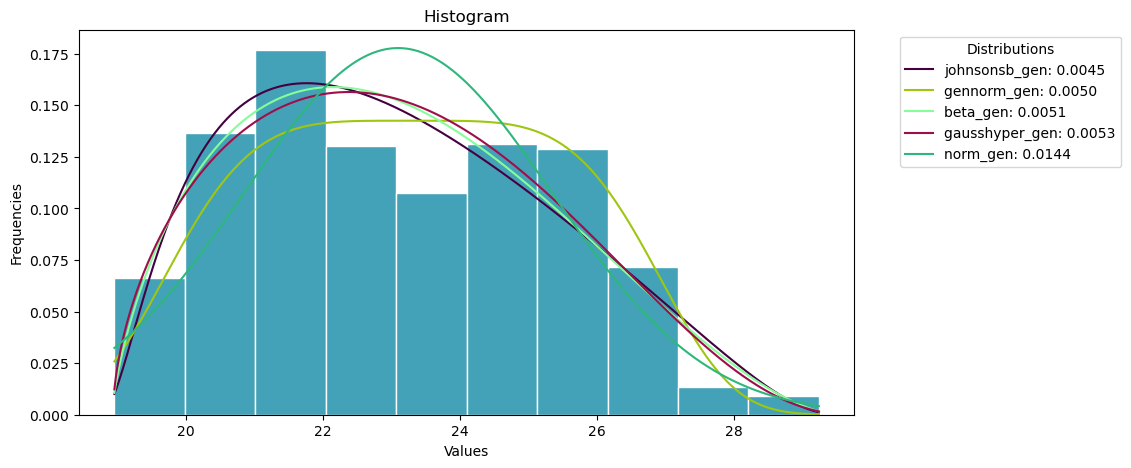

In [100]:
df = sm.datasets.elnino.load_pandas().data.set_index('YEAR')

data = pd.Series(df.values.ravel()) # df.ravel() - returns a flat array of data

results = fit_data(data)

plot_histogram(data, results, 5)

In [131]:
import math
import random
import re
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import pandas as pd

def doane_formula_v2(data):
    """
    Calculates the optimal number of bins for a histogram using Doane's formula.
    Reference: https://en.wikipedia.org/wiki/Histogram#Doane's_formula

    Parameters:
        data : array-like
            Input numerical data.
    
    Returns:
        int : optimal number of bins
    """
    N = len(data)
    skewness = st.skew(data)
    sigma_g1 = math.sqrt((6 * (N - 2)) / ((N + 1) * (N + 3)))
    num_bins = 1 + math.log(N, 2) + math.log(1 + abs(skewness) / sigma_g1, 2)
    return round(num_bins)


def fit_data_v2(data):
    """
    Fits a set of continuous distributions to the data and calculates SSE with histogram.

    Parameters:
        data : array-like
            Input numerical data.

    Returns:
        dict : mapping distribution -> [sse, shape_params, loc, scale], sorted by SSE
    """
    # List of candidate distributions
    MY_DISTRIBUTIONS = [st.beta, st.expon, st.norm,
                        st.uniform, st.johnsonsb, st.gennorm,
                        st.gausshyper]

    # Histogram for SSE calculation
    num_bins = doane_formula_v2(data)
    frequencies, bin_edges = np.histogram(data, num_bins, density=True)
    central_values = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

    results = {}
    for distribution in MY_DISTRIBUTIONS:
        # Suppress runtime warnings during fitting (common for beta/johnsonsb)
        with np.errstate(divide='ignore', invalid='ignore'):
            params = distribution.fit(data)

        # Unpack parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Evaluate PDF at bin centers
        pdf_values = np.array([
            distribution.pdf(c, *arg, loc=loc, scale=scale)
            for c in central_values
        ])

        # Replace nan/inf with zero
        pdf_values = np.nan_to_num(pdf_values, nan=0.0, posinf=0.0)

        # Sum of squared errors (histogram density vs PDF)
        sse = np.sum((frequencies - pdf_values) ** 2)

        # Store results
        results[distribution] = [sse, arg, loc, scale]

    # Sort distributions by SSE (best fit first)
    results = {k: results[k] for k in sorted(results, key=results.get)}
    return results

def plot_histogram_v2(data, results, n, limit_x_outliers=False, clip_y=False):
    """
    Plots a histogram of the data along with PDFs of top N fitted distributions.

    Parameters:
        data : array-like
            Input data to plot
        results : dict
            Fitting results from fit_data_v2()
        n : int
            Number of top distributions to plot
        limit_x_outliers : bool
            If True, limit x-range to 0.5–99.5 percentiles to avoid spikes
        clip_y : bool
            If True, clip extreme PDF values to 99th percentile for plotting
    """
    # Select top N distributions by SSE
    top_distributions = {k: results[k] for k in list(results)[:n]}

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(data, density=True, ec='white', color=(63/235, 149/235, 170/235))
    plt.title('Histogram')
    plt.xlabel('Values')
    plt.ylabel('Frequencies')

    # Plot fitted distributions
    for distribution, result in top_distributions.items():
        sse = result[0]
        arg = result[1]
        loc = result[2]
        scale = result[3]

        # Get theoretical support of the distribution
        x_min, x_max = distribution.support(*arg, loc=loc, scale=scale)

        # Optionally limit x to robust data percentiles to avoid spikes
        if limit_x_outliers:
            p_low, p_high = np.percentile(data, [0.5, 99.5])
        else:
            p_low, p_high = (min(data), max(data))
    
        # Intersection of support and data range
        plot_min = max(p_low, x_min)
        plot_max = min(p_high, x_max)

        if plot_min >= plot_max:
            continue  # skip if no valid range

        # X values for PDF plotting
        x_plot = np.linspace(plot_min, plot_max, 1000)

        try:
            y_plot = distribution.pdf(x_plot, *arg, loc=loc, scale=scale)
            # Replace NaN/inf with zero
            y_plot = np.nan_to_num(y_plot, nan=0.0, posinf=0.0)
            # Optionally clip extreme values for better visualization
            if clip_y:
                y_plot = np.clip(y_plot, 0, np.percentile(y_plot, 99))
        except Exception:
            continue  # skip unstable distributions (e.g., gausshyper in rare cases)

        # Clean distribution name
        dist_name = getattr(distribution, 'name', str(distribution).split()[0])

        plt.plot(
            x_plot, y_plot,
            label=f"{dist_name}: {str(sse)[:6]}",
            color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
        )

    plt.legend(title='Distributions', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


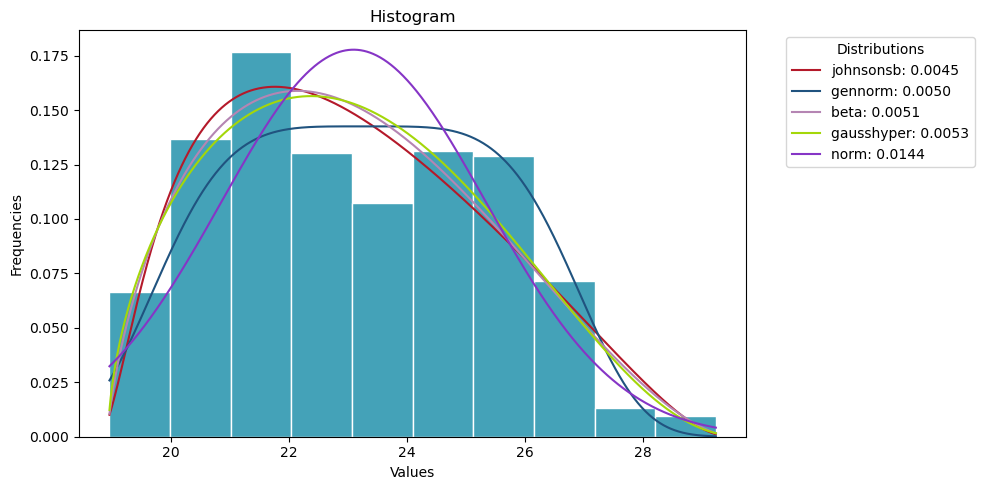

In [132]:
df = sm.datasets.elnino.load_pandas().data.set_index('YEAR')

data = pd.Series(df.values.ravel()) # df.ravel() - returns a flat array of data

results = fit_data_v2(data)

plot_histogram_v2(data, results, 5)

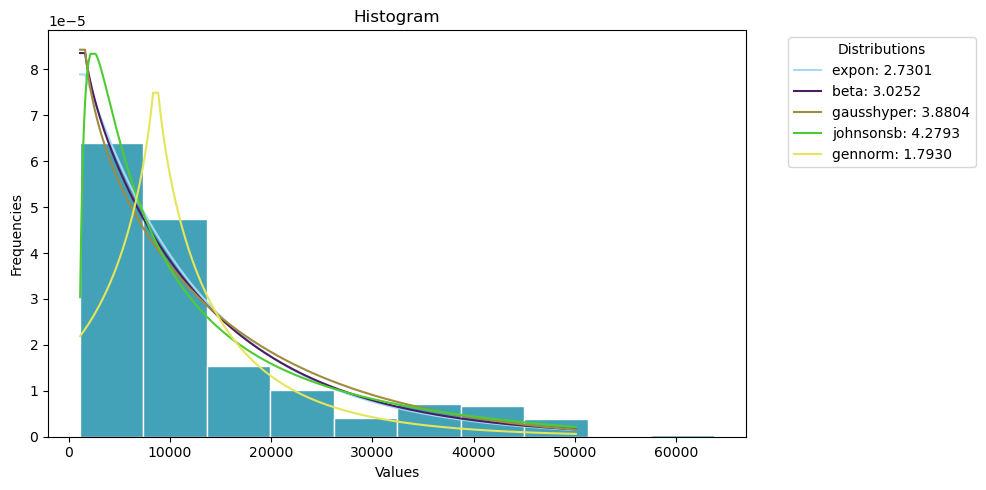

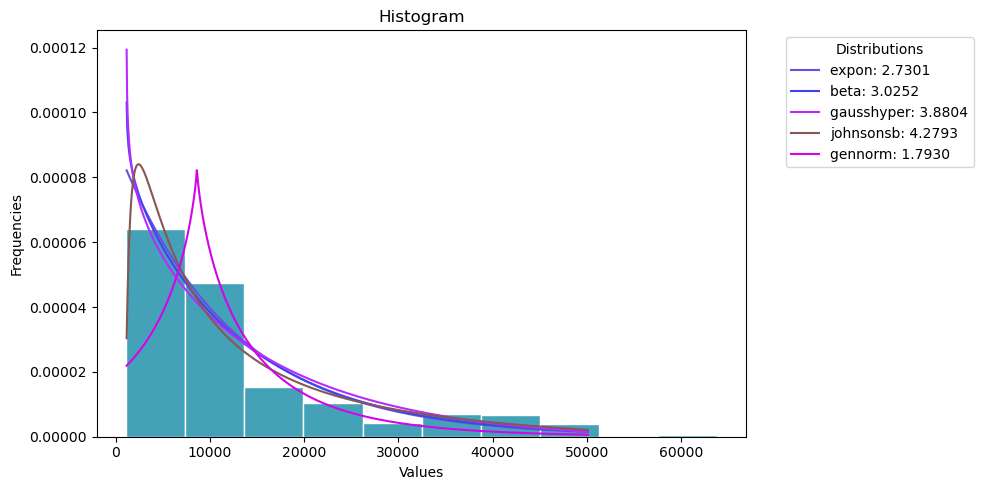

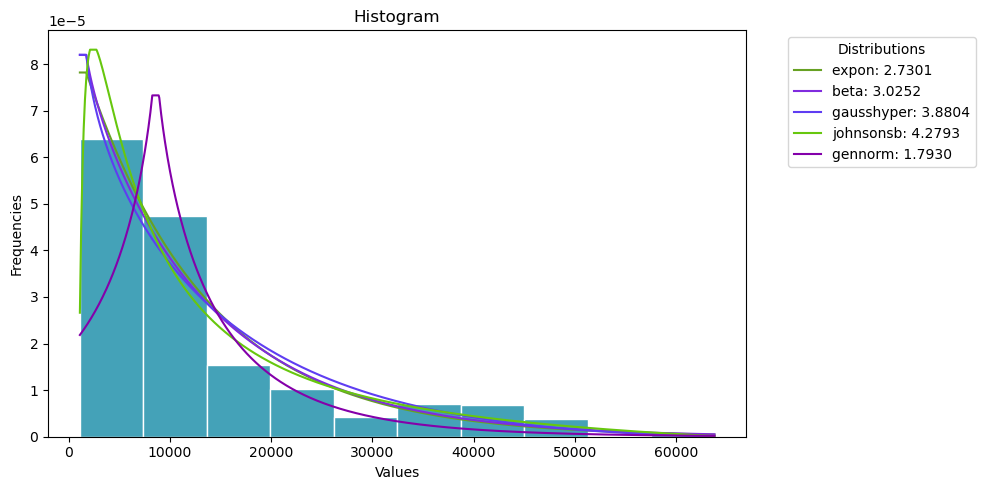

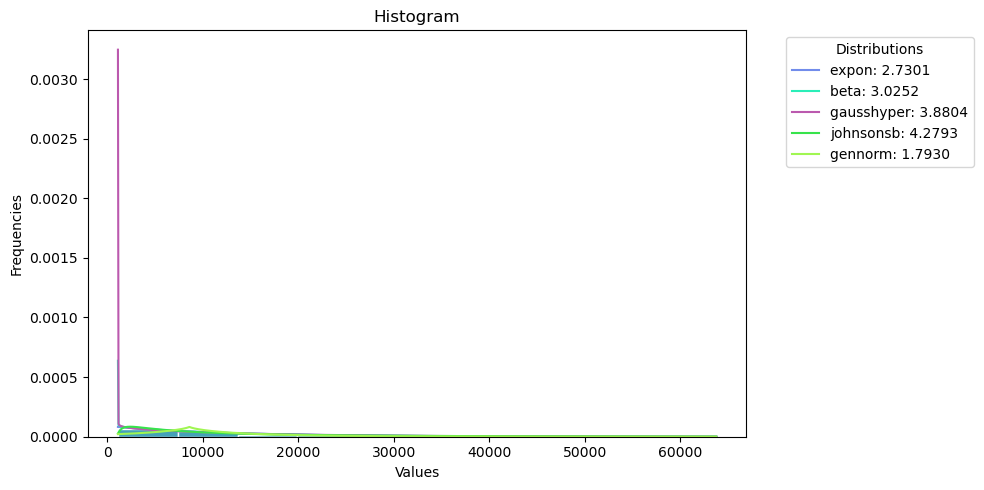

In [134]:
medical_df = pd.read_csv('data/medical-charges.csv')

data = medical_df['charges']

results = fit_data_v2(data)

plot_histogram_v2(data, results, n=5, limit_x_outliers=True, clip_y=True)

plot_histogram_v2(data, results, n=5, limit_x_outliers=True, clip_y=False)

plot_histogram_v2(data, results, n=5, limit_x_outliers=False, clip_y=True)

plot_histogram_v2(data, results, n=5, limit_x_outliers=False, clip_y=False)

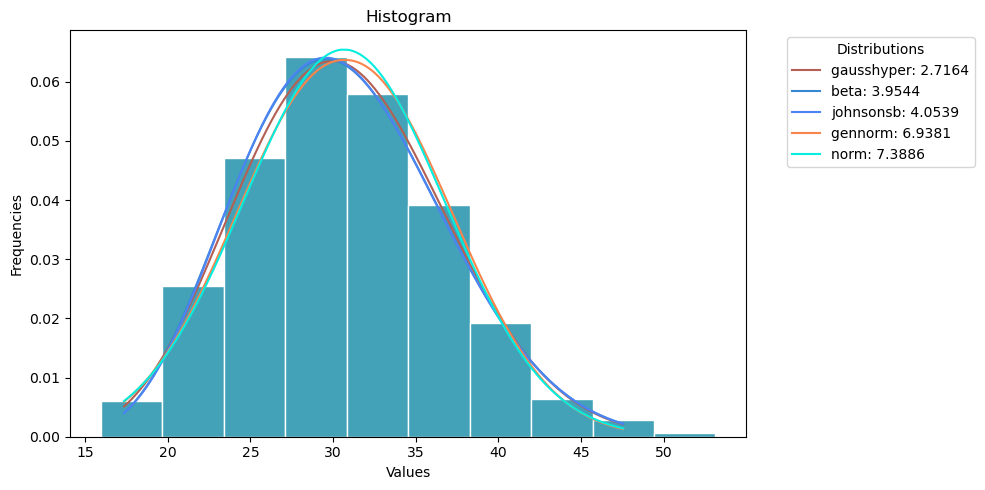

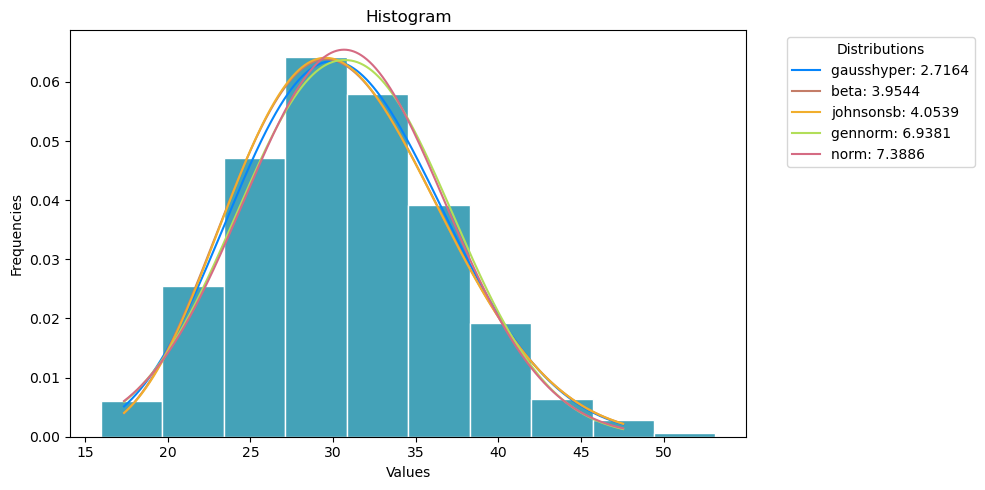

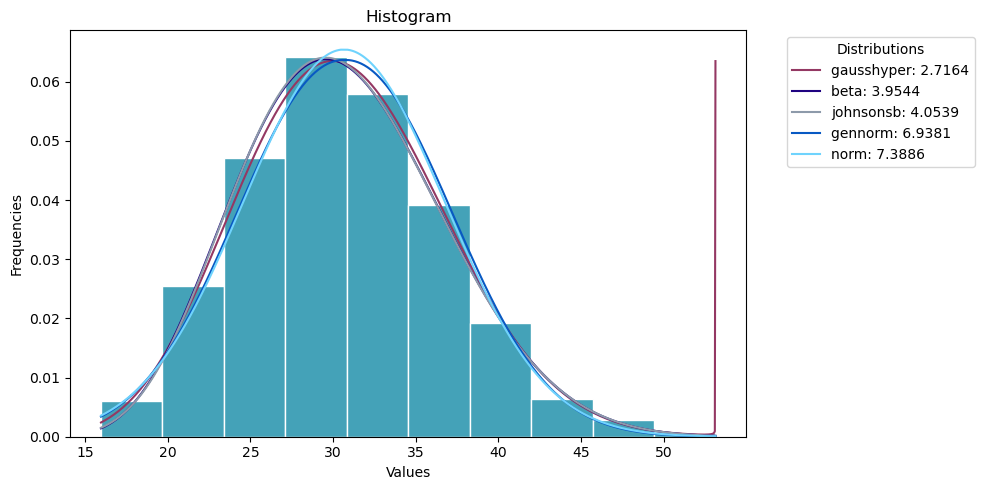

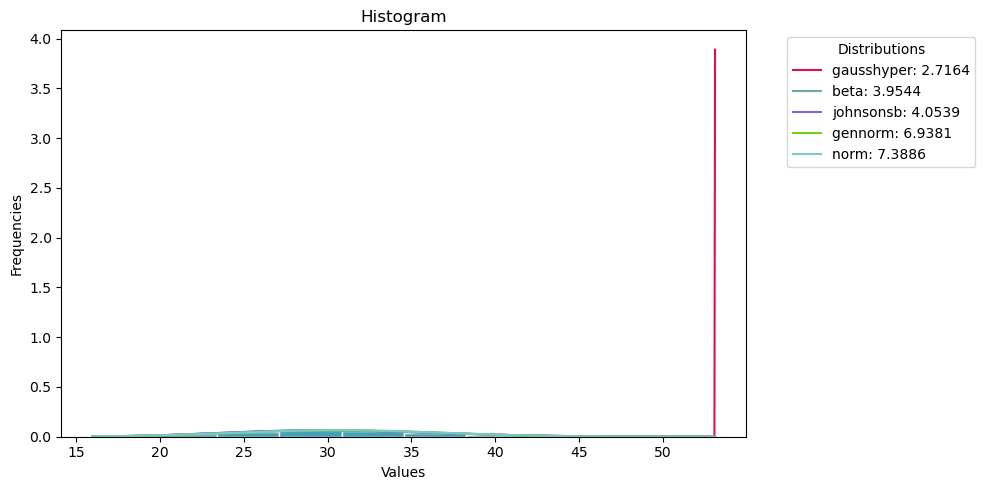

In [135]:
data = medical_df['bmi']

results = fit_data_v2(data)

plot_histogram_v2(data, results, n=5, limit_x_outliers=True, clip_y=True)

plot_histogram_v2(data, results, n=5, limit_x_outliers=True, clip_y=False)

plot_histogram_v2(data, results, n=5, limit_x_outliers=False, clip_y=True)

plot_histogram_v2(data, results, n=5, limit_x_outliers=False, clip_y=False)

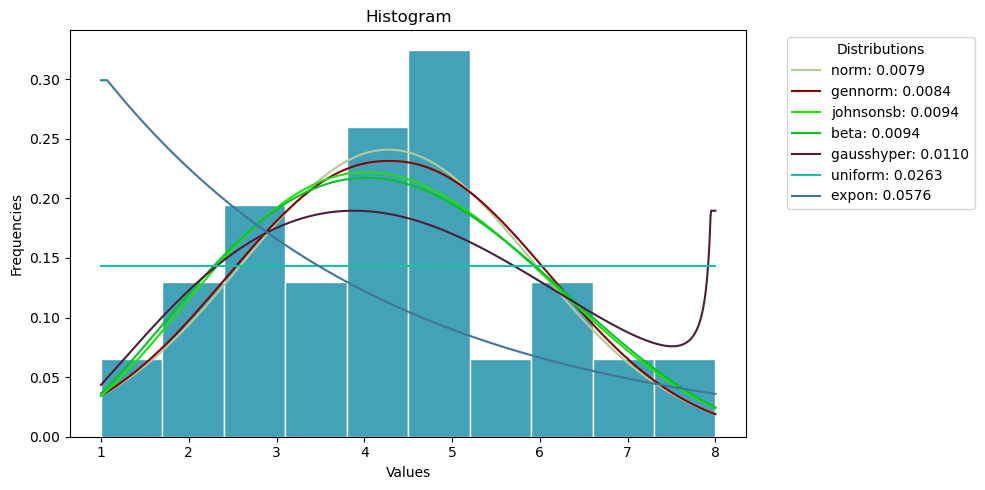

In [136]:
data = np.array([1,2,2,2.5,3,3,3.5, 3.5, 4,4,4,4,5,5,5,5,5,5.5,6,6,7,8])


results = fit_data_v2(data)

plot_histogram_v2(data, results, n=7, limit_x_outliers=False, clip_y=True)